### Stable Baselines are pre-trained agents that can be used for many gymnasium environments

In [1]:
# pip install stable-baselines3[extra]
import gymnasium as gym
from stable_baselines3 import DQN, PPO, A2C
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt

# display management
from IPython.display import clear_output
from IPython.utils import io

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [3]:
# create a custom callback in order to set a reward goal for the agent
# unfortunately there's no easier way to do this
class RewardThresholdCallback(BaseCallback):
    def __init__(self, reward_threshold, check_freq=1000, verbose=1):
        super().__init__(verbose)
        self.reward_threshold = reward_threshold
        self.check_freq = check_freq

    # override the on_step in the original model.learn
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            mean_reward = self.locals["infos"][-1].get("episode", {}).get("r")

            # see if we have matched our reward goal
            if mean_reward is not None and mean_reward >= self.reward_threshold:
                print(f"Stop training -> Target reward {self.reward_threshold} reached!")

                # stop training
                return False
            
        # otherwise continue training
        return True

In [4]:
# create model and train
# there's plenty of options to finetune the parameters
# this is just more or less a basic implementation where we aim for
# 500 total rewards
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=300000, callback=RewardThresholdCallback(500))

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.3     |
|    ep_rew_mean     | 22.3     |
| time/              |          |
|    fps             | 6791     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 25.5        |
|    ep_rew_mean          | 25.5        |
| time/                   |             |
|    fps                  | 4121        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008106104 |
|    clip_fraction        | 0.0991      |
|    clip_range           | 0.2         |
|    entropy_loss   

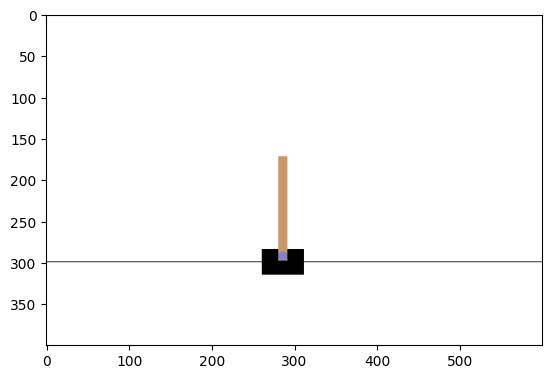

Total Reward: 1000.0


In [5]:
# make a new environment for the test
env = gym.make("CartPole-v1", render_mode="rgb_array")
state, info = env.reset()
total_reward = 0

# play the environment
for step in range(1000):
    action, _ = model.predict(state, deterministic=True)
    state, reward, done, truncated, info = env.step(action)
    total_reward += reward

    # visualize frame
    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    if done:
        break

# print result
print(f"Total Reward: {total_reward}")

# it plays pretty well already!